# Rift delineation using Random Forest

This notebook employs the Random Forest algorithm, an ensemble machine learning method, to classify each point along an ICESat-2 track based on whether or not that point lies within a rift. We start by selecting the number of decision trees to include in our forest:

In [1]:
trees = 100 #choose the number of decision trees

We then import all necessary packages and modules: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from scipy.signal import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

and set paths as necessary.

In [3]:
root_path = '/data/fast1/rift-id/'
outputs_path = root_path + 'outputs' #where the training data are stored

## Step 1: Load all relevant datasets

We'll load elevation profiles for each track and normalize each elevation profile by its maximal value. Meanwhile, we'll also load label arrays which label each point along each track as either "within a rift" (1) or "not within a rift" (0). These data will be used to together to train the rift delineation model.

In [4]:
training_data = pd.read_pickle(outputs_path + '/dml_all_bin_lr.pkl') #load the training data with rifted ice
elevation_profiles = np.array(training_data['h_subset']) #surface elevations along each track
labels = np.array(training_data['bin_subset']) #binary labels at each point along tracks

#and some other stuff for later verification
rift_names = training_data['rift'] #the names of each rift
x, y = training_data['x_subset'], training_data['y_subset'] #x and y coordinates along each track

### Modify the data 

In the loaded data, all training tracks have the rift positioned at the track center. However, this does not reflect real-world conditions, where rifts may appear at arbitrary locations (and generally, not all tracks will contain rifts). To improve the model's ability to detect rifts at any position along the track, we will modify the training data. Each track will be cropped to start and end at randomly-selected indices, so that the result may or may not contain a rift, and most rifts will generally not occur at the centre of the domain. We then resample the cropped tracks back to their original number of points.

In [5]:
elevation_profiles_cropped = []
labels_cropped = []

n = len(elevation_profiles[0])

for i in range(len(elevation_profiles)):
    for j in range(10): #in fact, why not do this many times just to increase the training sample?
        start_index = np.random.randint(n - 1) #start anywhere less than n
        end_index = np.random.randint(start_index + 1, high = n) #end anywhere between start_index and n
        
        temp_elev = elevation_profiles[i][start_index:end_index] #slice the track
        temp_elev = resample(temp_elev, n) #resample it to n points
        elevation_profiles_cropped.append(np.array(temp_elev))
        
        temp_label = labels[i][start_index:end_index] #slice
        temp_label = resample(temp_label, n) #resample
        labels_cropped.append(np.rint(np.array(temp_label))) #np.rint to ensure we don't end up with nonbinary labels

In [6]:
count = sum(1 in entry for entry in labels_cropped)
print(f'{count/len(labels_cropped)*100:.2f}% of cropped tracks contain rifts')

50.57% of cropped tracks contain rifts


## Step 2: Train the model

In [7]:
training_data = {
    'features': elevation_profiles_cropped,
    'labels': labels_cropped
}

X_train, X_test, Y_train, Y_test = train_test_split(training_data['features'], training_data['labels'], 
                                                    test_size = 0.1, random_state=0)
model = RandomForestClassifier(n_estimators = trees)
model.fit(X_train, Y_train)
score = model.score(X_test,Y_test)
print(f'model score: {100*score : 0.2f}%')

model score:  48.86%


## Step 3: Test the model

We test the model by selecting a named rift, identifying all ICESat-2 tracks that contain it, and attempting to reproduce its classification.

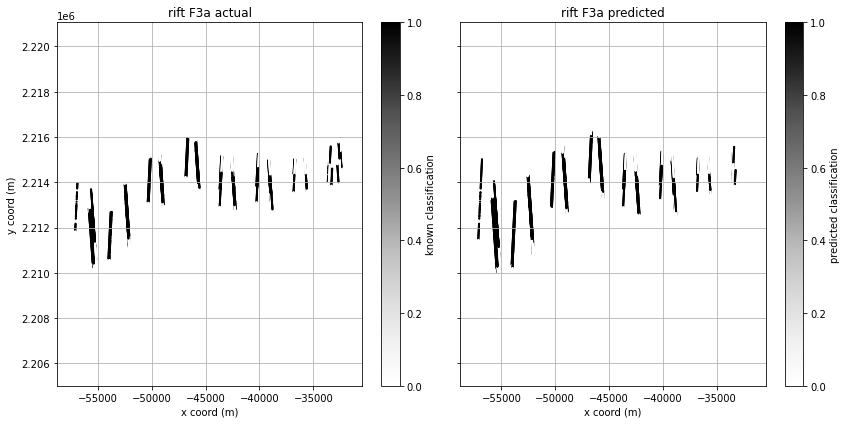

In [8]:
test_rift = 'F3a' #choose a rift
mask = np.array(rift_names) == test_rift  #Boolean mask for matching the chosen rift name
test_tracks = [np.array(elevation_profiles[i]) for i in np.where(mask)[0]] #select relevant tracks
test_labels = [np.array(labels[i]) for i in np.where(mask)[0]] #and labels
x_subset = [np.array(x[i]) for i in np.where(mask)[0]] #x-coords
y_subset = [np.array(y[i]) for i in np.where(mask)[0]] #y-coords

output_labels = model.predict(test_tracks) #get model predictions

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True) #and plot

#first subplot: known classification
sc1 = axes[0].scatter(x_subset, y_subset, s=1, c=test_labels, cmap='Greys')
cbar1 = fig.colorbar(sc1, ax=axes[0])
cbar1.set_label('known classification')
axes[0].set_xlabel('x coord (m)')
axes[0].set_ylabel('y coord (m)')
axes[0].grid()
axes[0].set_title(f'rift {test_rift} actual')

#second subplot: predicted classification
sc2 = axes[1].scatter(x_subset, y_subset, s=1, c=output_labels, cmap='Greys')
cbar2 = fig.colorbar(sc2, ax=axes[1])
cbar2.set_label('predicted classification')
axes[1].set_xlabel('x coord (m)')
axes[1].grid()
axes[1].set_title(f'rift {test_rift} predicted')

plt.tight_layout()
plt.show()